In [41]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

In [42]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [43]:
X = X.values
y = y.astype(int).values

In [44]:
print(X.shape, y.shape)

(70000, 784) (70000,)


In [45]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [46]:
#normalization to range -1, 1
X = ((X/255.) - .5)*2


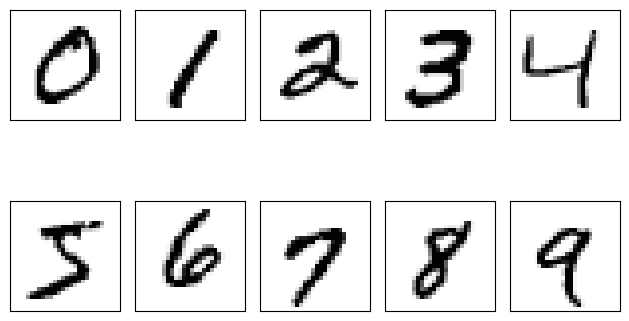

In [47]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5,sharex=True, sharey=True)

ax = ax.flatten()
for i in range(10):
    img = X[y==i][0].reshape(28,28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

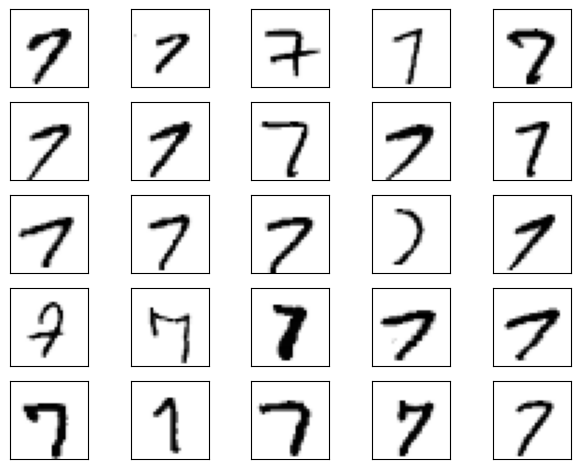

In [48]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y==7][i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [49]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

In [50]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def int_to_onehot(y, num_labels):
    arr = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        arr[i, val] = 1
    return arr

In [51]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes

        rng = np.random.RandomState(random_seed)
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features)
        )
        self.bias_h = np.zeros(num_hidden)

        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden)
        )
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out
    
    def backward(self, x, a_h, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output layer dim: [n_examples, n_classes]
        d_loss_d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output layer dim: [n_examples, n_classes]
        d_a_out_d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output layer dim: [n_examples, n_classes]
        delta_out = d_loss_d_a_out * d_a_out_d_z_out

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out_d_w_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss_dw_out = np.dot(delta_out.T, d_z_out_d_w_out)
        d_loss_db_out = np.sum(delta_out, axis=0)

        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out_a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss_a_h = np.dot(delta_out, d_z_out_a_h)

        # [n_examples, n_hidden]
        d_a_h_d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h_d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss_d_w_h = np.dot((d_loss_a_h * d_a_h_d_z_h).T, d_z_h_d_w_h)
        d_loss_d_b_h = np.sum((d_loss_a_h * d_a_h_d_z_h), axis=0)

        return (d_loss_dw_out, d_loss_db_out, d_loss_d_w_h, d_loss_d_b_h)

In [52]:
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

In [53]:
num_epochs = 50
mini_batch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

In [54]:
for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, mini_batch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
print(X_train_mini.shape, y_train_mini.shape)
    

(100, 784) (100,)


In [55]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(targets == predicted_labels)

In [56]:
_, probas = model.forward(X_val)
mse = mse_loss(y_val, probas)
print(f'Initial val MSE: {mse:.1f}')

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_val, predicted_labels)
print(f'Initial val accuracy: {acc*100:.1f}%')


Initial val MSE: 0.3
Initial val accuracy: 9.4%


In [57]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += np.sum(predicted_labels == targets)
        num_examples += targets.shape[0]
        mse += loss
    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [58]:
mse, acc = compute_mse_and_acc(model, X_val, y_val)
print(f'Initial val MSE: {mse:.1f}')
print(f'Initial val accuracy: {acc*100:.1f}%')

Initial val MSE: 0.3
Initial val accuracy: 9.4%


In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, mini_batch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            ### Compute outputs ###
            a_h, a_out = model.forward(X_train_mini)

            ### Compute gradients ###
            d_loss_d_w_out, d_loss_d_b_out, d_loss_d_w_h, d_loss_d_b__h = model.backward(
                X_train_mini, a_h, a_out, y_train_mini
            )

            ### Update weights ###
            model.weight_out -= learning_rate * d_loss_d_w_out
            model.bias_out -= learning_rate * d_loss_d_b_out
            model.weight_h -= learning_rate * d_loss_d_w_h
            model.bias_h -= learning_rate * d_loss_d_b__h

        ### Epoch Logging ###
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} | '
              f'Train MSE: {train_mse:.2f} | Validation MSE: {valid_mse:.2f} | '
              f'Train Acc: {train_acc:.2f}% | Validation Acc: {valid_acc:.2f}%')
    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [60]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_val, y_val, num_epochs=50, learning_rate=0.1
)

Epoch: 001/050 | Train MSE: 0.05 | Validation MSE: 0.05Train Acc: 76.15% | Validation Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Validation MSE: 0.03Train Acc: 85.45% | Validation Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Validation MSE: 0.02Train Acc: 87.82% | Validation Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Validation MSE: 0.02Train Acc: 89.36% | Validation Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Validation MSE: 0.02Train Acc: 90.21% | Validation Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Validation MSE: 0.02Train Acc: 90.67% | Validation Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Validation MSE: 0.02Train Acc: 91.12% | Validation Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Validation MSE: 0.02Train Acc: 91.43% | Validation Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Validation MSE: 0.02Train Acc: 91.84% | Validation Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Validation MSE: 0.01Train Acc: 92.04% | Validation Acc: 91.84%
Epoch: 011/050 | Tra

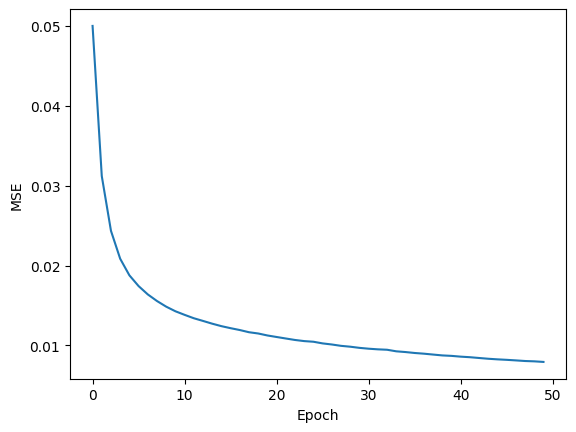

In [61]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

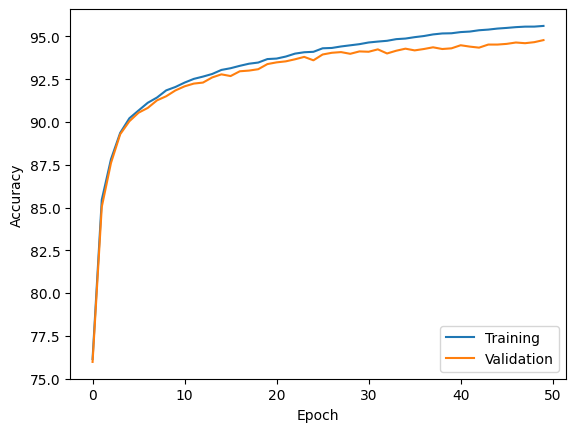

In [63]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [64]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%


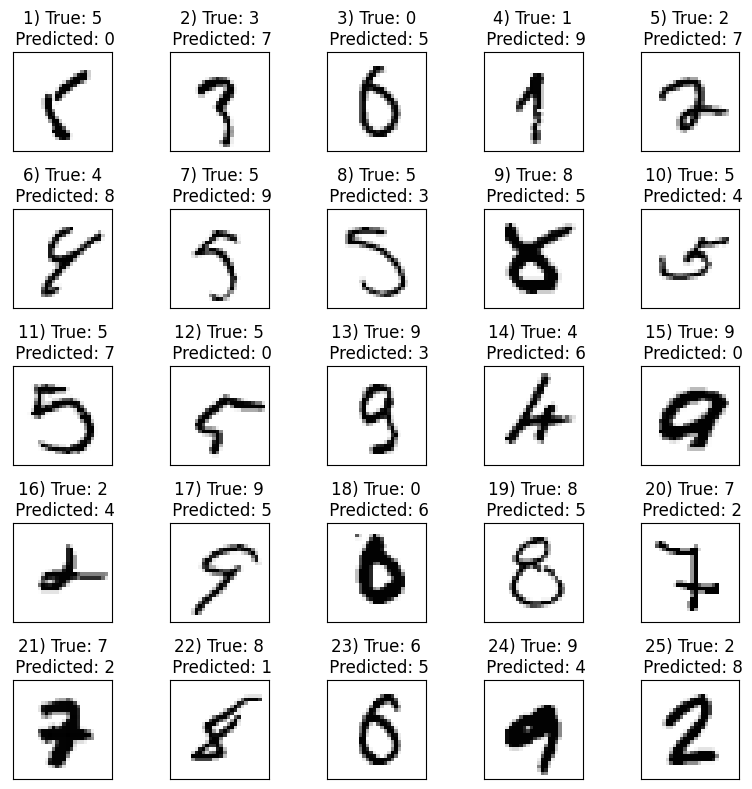

In [65]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

array([5, 0, 4, ..., 4, 5, 6], shape=(70000,))

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(70000, 10))